# **Feature Engineering**

## Objectives

* Create new features to improve model predictions.
* Transform and combine existing features.
* Explore the relationships between features and the target variable.

## Inputs

* Cleaned dataset: `outputs/datasets/collection/HousePricesRecords.csv`
* Data with handled missing values and correct data types.

## Outputs

* New dataset with engineered features: `outputs/datasets/feature_engineered/HousePricesFeatures.csv`
* Visualizations (if applicable): Charts showing feature relationships and distributions.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

## Load data

In [10]:
import pandas as pd
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("outputs/datasets/collection/HousePricesCleaned.csv")
print(df[['2ndFlrSF', 'BedroomAbvGr', 'SalePrice']].head())

   2ndFlrSF  BedroomAbvGr  SalePrice
0  1.291464      0.137500   0.553334
1 -0.762109      0.137500   0.094270
2  1.320320      0.137500   0.808369
3 -0.762109      0.137500  -0.611328
4 -0.762109      1.471143   1.258931


In [7]:
df.dtypes

1stFlrSF        float64
2ndFlrSF        float64
BedroomAbvGr    float64
BsmtExposure     object
BsmtFinSF1      float64
BsmtFinType1     object
BsmtUnfSF       float64
GarageArea      float64
GarageFinish     object
GarageYrBlt     float64
GrLivArea       float64
KitchenQual      object
LotArea         float64
LotFrontage     float64
MasVnrArea      float64
OpenPorchSF     float64
OverallCond     float64
OverallQual     float64
TotalBsmtSF     float64
YearBuilt       float64
YearRemodAdd    float64
SalePrice       float64
dtype: object

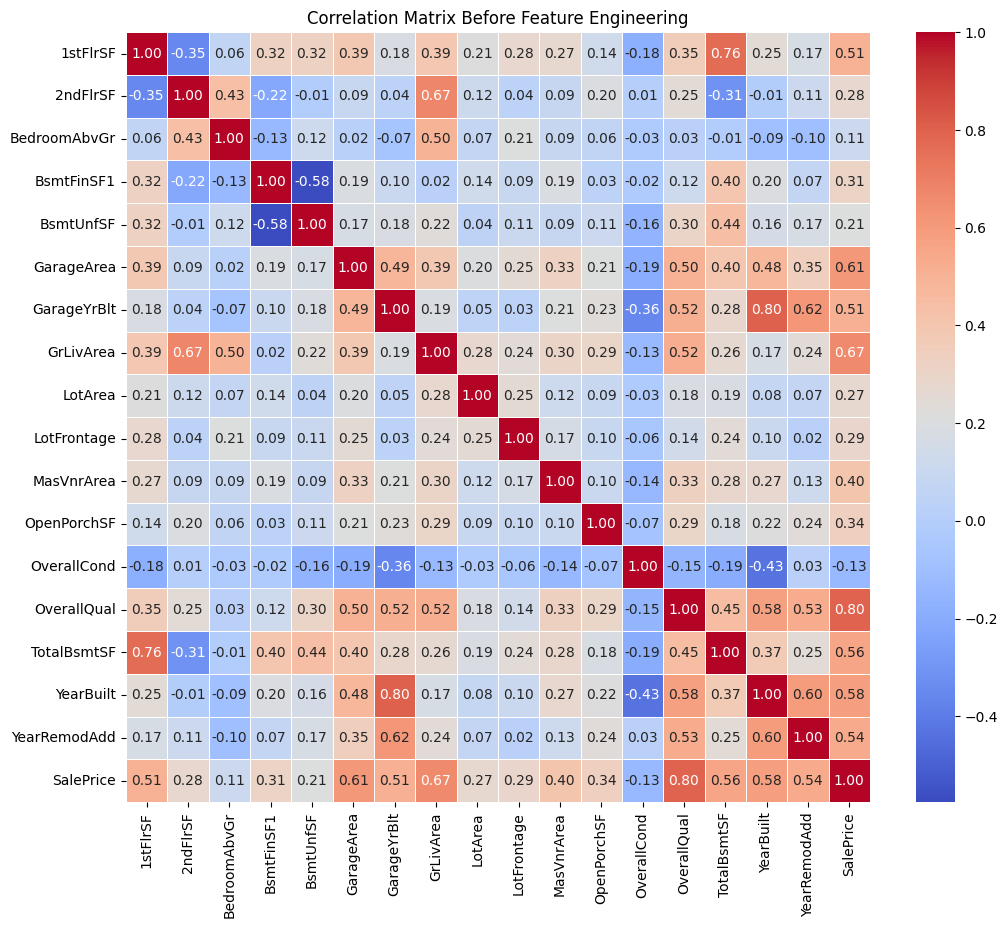

In [8]:
# Show the correlation matrix before feature engineering
correlation_matrix_before = df.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_before, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Before Feature Engineering")
plt.show()

**Correlation Matrix Before Feature Engineering**

The correlation matrix helps see how features relate to the target "SalePrice" before starting the feature engineering process. This helps decide which features are important and which can be combined or removed to make the model better.

Key Insights:

* **GrLivArea (0.67)** and **OverallQual (0.80)** have strong positive correalation to "SalePrice" making them important. New features could be created based on these to better capture house value.
* **GarageArea (0.61)** and **YearBuilt (0.58)** also show strong correlations, indicating that larger garages and newer construction add value.
* **BedroomAbvGr (0.11)** and **OverallCond (-0.13)** have weak links to "SalePrice". These may be improved, combined, or removed.

In [11]:
# Identify and OneHotEncode categorical variables
one_hot_encoder = OneHotEncoder(variables=['KitchenQual', 'GarageFinish', 'BsmtExposure', 'BsmtFinType1'])
df_encoded = one_hot_encoder.fit_transform(df)

# Select only numeric columns
df_numeric = df_encoded.select_dtypes(include=['float64', 'int64'])

# Generate the correlation matrix
correlation_matrix = df_numeric.corr()

In [25]:
# Filter correlations above a threshold
threshold = 0.4
high_corr = correlation_matrix['SalePrice'][abs(correlation_matrix['SalePrice']) > threshold]
print("Variables with high correlation with SalePrice:")
print(high_corr.sort_values(ascending=False))

Variables with high correlation with SalePrice:
SalePrice           1.000000
OverallQual         0.796281
GrLivArea           0.666410
GarageArea          0.611429
YearBuilt           0.581749
TotalBsmtSF         0.558263
YearRemodAdd        0.537774
GarageYrBlt         0.512484
1stFlrSF            0.507141
KitchenQual_Gd      0.440811
BsmtFinType1_GLQ    0.417676
MasVnrArea          0.404710
GarageFinish_Unf   -0.454870
KitchenQual_TA     -0.565973
Name: SalePrice, dtype: float64


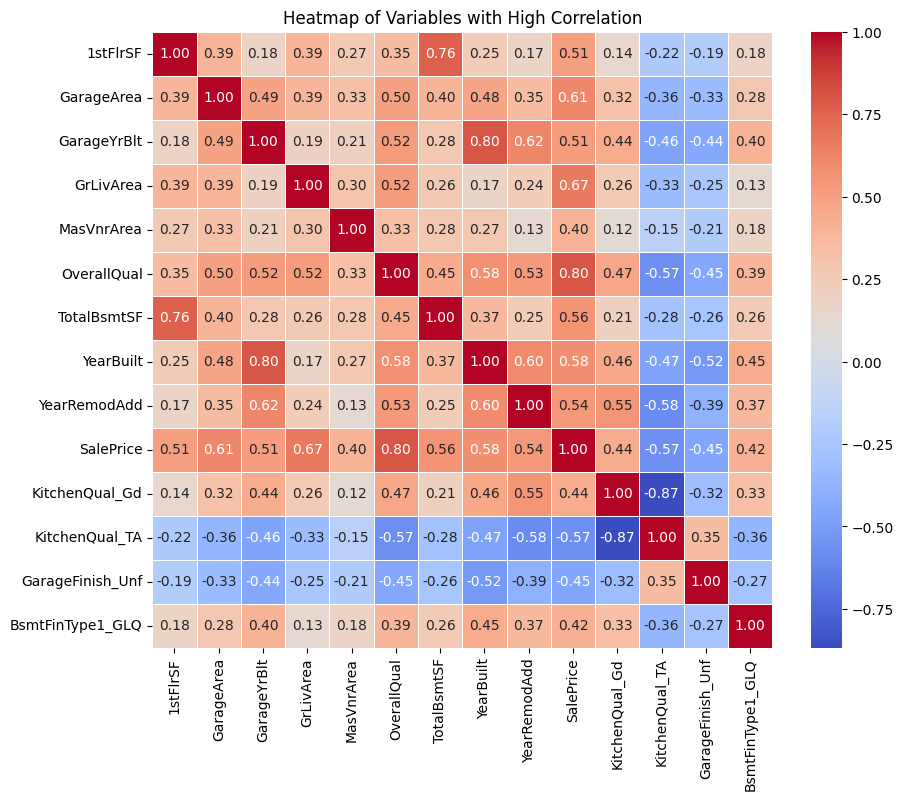

In [26]:
# Filter variables with correlation > 0.5 with SalePrice
threshold = 0.4
high_corr = correlation_matrix['SalePrice'][abs(correlation_matrix['SalePrice']) > threshold]

# Get the names of relevant variables
relevant_vars = high_corr.index

# Create a filtered correlation matrix with only these variables
filtered_corr_matrix = correlation_matrix.loc[relevant_vars, relevant_vars]

# Plot heatmap for filtered variables
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Variables with High Correlation")
plt.show()


Display correlation matrix, helping identify relationships before feature engineering.

**Correlation Matrix After Feature Engineering**

The updated correlation matrix highlights how features relate to the target variable "SalePrice" after performing feature engineering. This analysis helps determine which features remain important and which newly engineered features contribute to better model predictions.

**Key Insights:**
Strong correlations with SalePrice:

* **OverallQual (0.80)** and **GrLivArea (0.67)** still show strong positive correlations, indicating their continued importance in predicting house prices.
* **GarageArea (0.61)** and **TotalBsmtSF (0.56)** also maintain strong correlations, reinforcing their value in the model.
* **YearBuilt (0.58)** and **YearRemodAdd (0.54)** have similar positive correlations, showing that both features reflect the age and updates of the house, which are important for predicting its price.

**Newly engineered features:**

* **KitchenQual_Gd (0.44)** created through OneHotEncoding, shows a moderate positive correlation with SalePrice, indicating that better kitchen quality adds value.

* **BsmtFinType1_GLQ (0.42)** another encoded feature, shows a moderate positive correlation with SalePrice indicating that good quality finished basement adds value.

**Weak correlations with SalePrice:**

* **KitchenQual_TA (-0.36)** and **GarageFinish_Unf (-0.27)** have weaker correlations, indicating their impact on house price may be less significant.

This matrix provides a more refined perspective after feature engineering, allowing for the identification of engineered features that improve the model’s performance and those that could be reconsidered.

___

Check for missing values before one-hot encoding

In [27]:
missing_values_before_encoding = X_categorical.isnull().sum()
print("Missing values before one-hot encoding:")
print(missing_values_before_encoding[missing_values_before_encoding > 0])


NameError: name 'X_categorical' is not defined

 No missing values found in categorical columns after one-hot encoding

___

* **Encode categorical variables:** Turn category columns into numbers so the model can use them.
* **Boolean columns:** Change True/False to 0 and 1 for the model.
* **Separate columns:** Split numeric and category columns to handle them better, like scaling numbers.

In [84]:
# Categorical and numerical columns
categorical_columns = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
numerical_columns = ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea', 'GrLivArea', 'OverallQual']

# Select numerical data
X_numerical = df[numerical_columns]

# Used one-hot encoding for categories
X_categorical = df[categorical_columns]
X_categorical_encoded = pd.get_dummies(X_categorical)

# Changed boolean columns to 0 and 1
X_categorical_encoded = X_categorical_encoded.astype(int)

* Combine columns to put all the numeric and encoded category columns together in one dataset.
* Scale numbers to make all numeric values similar in range to help the model work better.

In [85]:
# Combined numbers and encoded categories
X_combined = pd.concat([X_numerical, X_categorical_encoded], axis=1)

# Create a pipeline to scale numbers
pipeline = Pipeline([
    ('scaler', StandardScaler())
])


* Scale the numeric features so they are all on a similar range.
* Add 'SalePrice' to the transformed dataset.
* Print the dataset size, first few rows, and data types after transformation.
* Print an error message if something goes wrong.

In [86]:
try:
    # Scale numerical features using the pipeline
    X_combined[numerical_columns] = pipeline.fit_transform(X_combined[numerical_columns])

    # Include SalePrice in the transformed dataset
    X_combined['SalePrice'] = df['SalePrice']

    # Display information about the transformed dataset
    print("Transformed dataset size:", X_combined.shape)
    print(X_combined.head())
    print(X_combined.dtypes)

except Exception as e:
    print("Error during pipeline execution:", e)

Transformed dataset size: (1290, 24)
   2ndFlrSF  BedroomAbvGr  BsmtFinSF1  GarageArea  GrLivArea  OverallQual  \
0  1.291464      0.137500    0.679276    0.385419   0.517712     0.735143   
1 -0.762109      0.137500    1.339854   -0.068010  -0.537289    -0.070579   
2  1.320320      0.137500    0.144985    0.694576   0.696686     0.735143   
3 -0.762109      0.137500   -0.510736    0.869764   0.534197     0.735143   
4 -0.762109      1.471143    0.555418    1.869371   1.666910     1.540864   

   BsmtExposure_Av  BsmtExposure_Gd  BsmtExposure_Mn  BsmtExposure_No  ...  \
0                0                0                0                1  ...   
1                0                1                0                0  ...   
2                0                0                1                0  ...   
3                0                0                0                1  ...   
4                1                0                0                0  ...   

   BsmtFinType1_Rec  BsmtFinTyp

___

Check for missing values after one-hot encoding

In [87]:
missing_values_after_encoding = X_categorical_encoded.isnull().sum()
print("Missing values after one-hot encoding:")
print(missing_values_after_encoding[missing_values_after_encoding > 0])

Missing values after one-hot encoding:
Series([], dtype: int64)


 No missing values found in categorical columns after one-hot encoding

___

In [88]:
# Print the shape and columns of the DataFrame to verify changes after operations
print("DataFrame shape after operation:", df.shape)
print("DataFrame columns after operation:", df.columns.tolist())

DataFrame shape after operation: (1290, 22)
DataFrame columns after operation: ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtUnfSF', 'GarageArea', 'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice']


Create a **heatmap** to visualize the correlation matrix **after** Feature Engineering

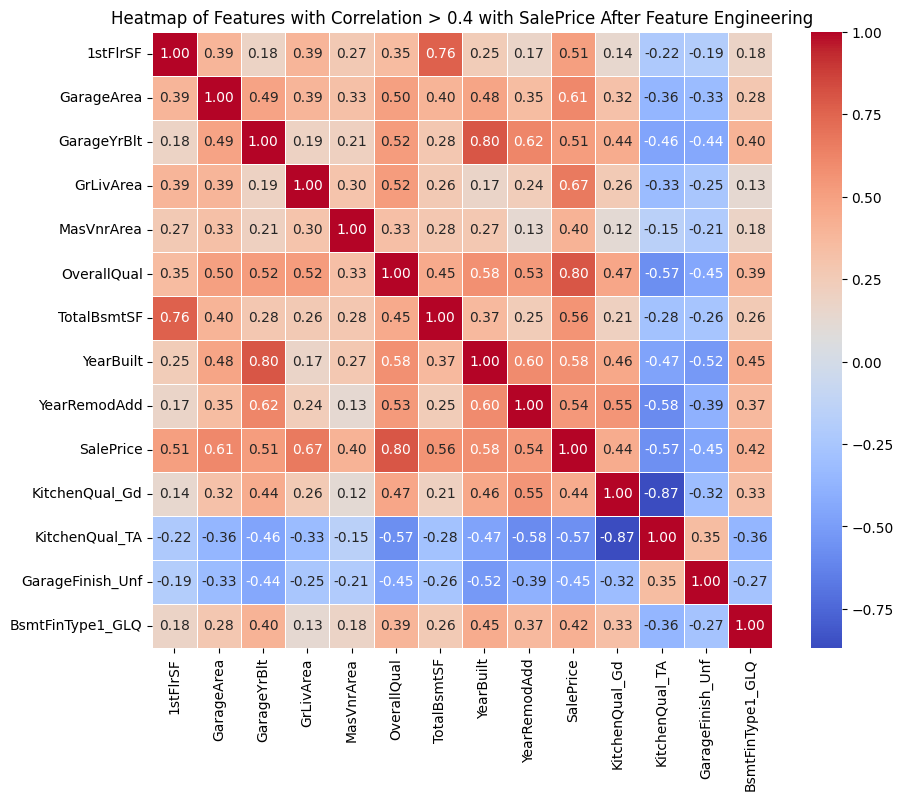

In [101]:
# Filter variables with correlation > 0.4 with SalePrice
threshold = 0.4
high_corr = correlation_matrix_after['SalePrice'][abs(correlation_matrix_after['SalePrice']) > threshold]

# Get the names of relevant variables
relevant_vars = high_corr.index

# Create a filtered correlation matrix with only these variables
filtered_corr_matrix = correlation_matrix_after.loc[relevant_vars, relevant_vars]

# Plot heatmap for variables with high correlation
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Features with Correlation > 0.4 with SalePrice After Feature Engineering")
plt.show()

## **CHANGE!!!!**
**Correlation Matrix After Feature Engineering** ## CHANGE!!!!

The updated correlation matrix shows the impact of feature engineering:

* **OverallQual (0.80)** This feature has the strongest positive correlation with SalePrice, indicating that higher-quality homes tend to sell for more. It's a crucial predictor for the model.

* **OverallCond (-0.13)** This feature shows a very weak correlation with SalePrice, suggesting it has little impact on house prices and may not add much value to the model.

* **GrLivArea (0.67)** and **GarageArea (0.61)** Both continue to show strong positive correlations with SalePrice, reaffirming their importance in predicting house prices.

The goal of feature engineering was to enhance the representation of important features and reduce redundancy. By focusing on features with strong correlations, such as OverallQual and GrLivArea, the model can better predict house prices while minimizing the impact of less significant features.

___

In [103]:
# Filter high correlation features related to SalePrice
high_corr_with_target = correlation_matrix['SalePrice'][correlation_matrix['SalePrice'] >= threshold]
print("Features with high correlation to SalePrice:", high_corr_with_target)

Features with high correlation to SalePrice: 1stFlrSF            0.507141
GarageArea          0.611429
GarageYrBlt         0.512484
GrLivArea           0.666410
MasVnrArea          0.404710
OverallQual         0.796281
TotalBsmtSF         0.558263
YearBuilt           0.581749
YearRemodAdd        0.537774
SalePrice           1.000000
KitchenQual_Gd      0.440811
BsmtFinType1_GLQ    0.417676
Name: SalePrice, dtype: float64


### Hypothesis 1 Confirmed
The scatter plots and correlation analysis show a positive relationship between the total area of the house and its sale price, confirming the initial hypothesis that bigger houses tend to have higher sale prices.

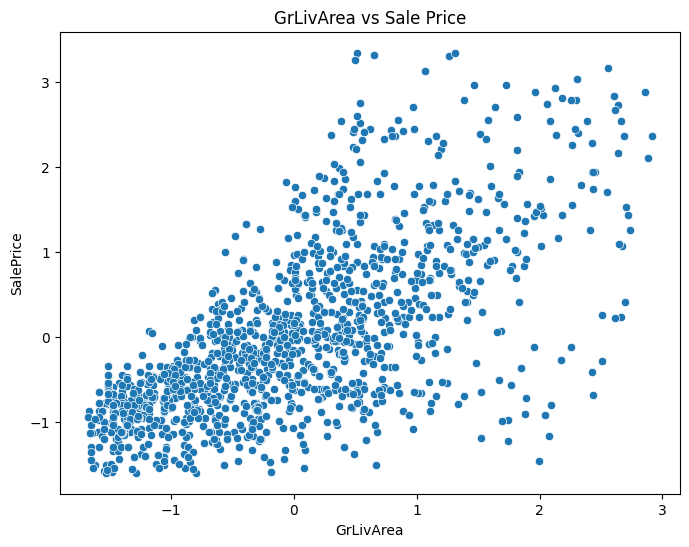

In [104]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('GrLivArea vs Sale Price')
plt.show()

### Hypothesis 2 Confirmed
* The scatter plot and correlation analysis show a strong positive link between OverallQual and SalePrice. With a correlation of 0.80, higher quality homes tend to sell for more. This confirms that home quality affects its sale price.

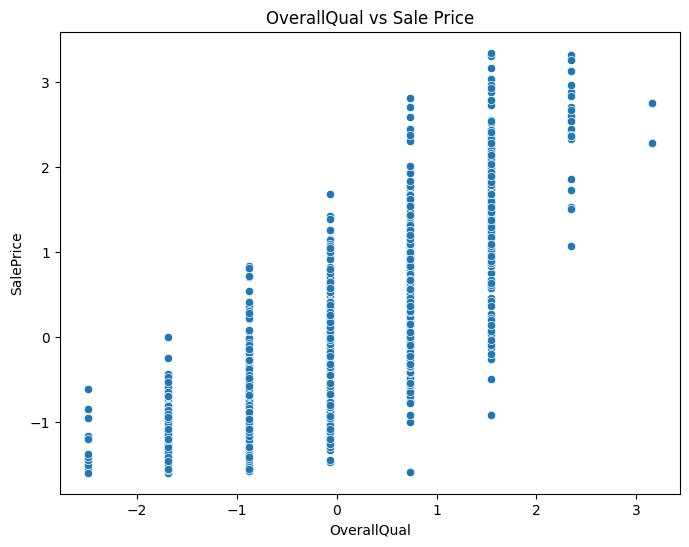

In [105]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='OverallQual', y='SalePrice', data=df)
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.title('OverallQual vs Sale Price')
plt.show()

### Hypothesis 3 Confirmed
The scatter plot and correlation analysis show a positive relationship between 'GarageArea' and 'SalePrice'. This confirms the hypothesis that houses with bigger garages tend to sell for higher prices.

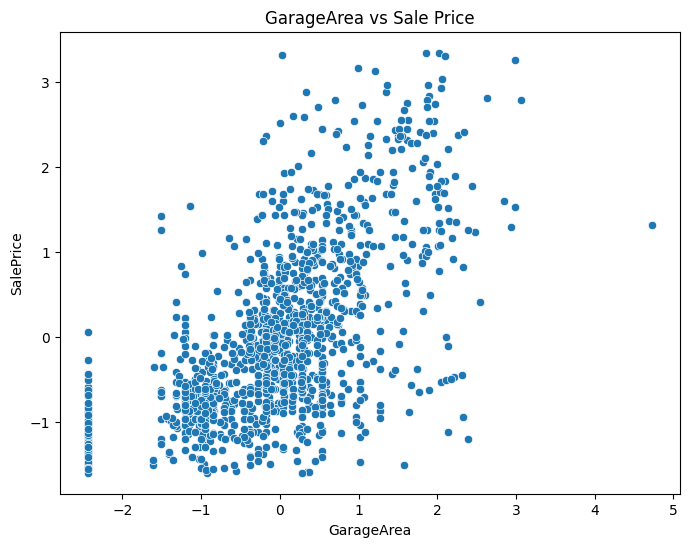

In [107]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GarageArea', y='SalePrice', data=df)
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')
plt.title('GarageArea vs Sale Price')
plt.show()

In [108]:
print(X_combined.dtypes)

2ndFlrSF            float64
BedroomAbvGr        float64
BsmtFinSF1          float64
GarageArea          float64
GrLivArea           float64
OverallQual         float64
BsmtExposure_Av       int64
BsmtExposure_Gd       int64
BsmtExposure_Mn       int64
BsmtExposure_No       int64
BsmtFinType1_ALQ      int64
BsmtFinType1_BLQ      int64
BsmtFinType1_GLQ      int64
BsmtFinType1_LwQ      int64
BsmtFinType1_Rec      int64
BsmtFinType1_Unf      int64
GarageFinish_Fin      int64
GarageFinish_RFn      int64
GarageFinish_Unf      int64
KitchenQual_Ex        int64
KitchenQual_Fa        int64
KitchenQual_Gd        int64
KitchenQual_TA        int64
SalePrice           float64
dtype: object


Print the number of unique values in each column

In [109]:
print(df.nunique())
print(df['SalePrice'].unique())

1stFlrSF        675
2ndFlrSF        360
BedroomAbvGr      7
BsmtExposure      4
BsmtFinSF1      574
BsmtFinType1      6
BsmtUnfSF       729
GarageArea      403
GarageFinish      3
GarageYrBlt      96
GrLivArea       766
KitchenQual       4
LotArea         683
LotFrontage     103
MasVnrArea      290
OpenPorchSF     182
OverallCond       8
OverallQual       8
TotalBsmtSF     650
YearBuilt       109
YearRemodAdd     61
SalePrice       569
dtype: int64
[ 5.53333604e-01  9.42699531e-02  8.08368966e-01 -6.11327881e-01
  1.25893144e+00 -5.60320809e-01  2.22806581e+00  4.08813566e-01
 -7.83051691e-01 -9.85379745e-01 -7.89852634e-01  2.87415540e+00
 -5.43318451e-01  1.76050098e+00 -3.22287804e-01 -7.47346741e-01
 -4.58306664e-01 -1.46144575e+00 -2.88283089e-01 -6.28330238e-01
  2.53920895e+00 -6.21529295e-01  9.18884289e-01 -3.73294877e-01
  1.36604629e+00 -6.99740140e-01  2.21106346e+00  5.36331247e-01
 -4.52355839e-01  6.70661812e-02 -1.77767766e-01  1.72649627e+00
  2.26207053e+00 -5.2631609

___

In [110]:
# Calculate the correlation between features and SalePrice
correlation = X_combined.corr()['SalePrice'].sort_values(ascending=False)

# Select features that have a strong correlation
selected_features = correlation[abs(correlation) > 0.4].index.tolist()

# Remove 'SalePrice' from the features
selected_features.remove('SalePrice')

print(selected_features)

# Filter the dataset to only keep the selected features and SalePrice
X_selected = X_combined[selected_features + ['SalePrice']]

# Save the filtered dataset to a CSV file
X_selected.to_csv("outputs/datasets/collection/HousePricesFeaturesSelected.csv", index=False)
print("Exported the reduced dataset with important features!")


['OverallQual', 'GrLivArea', 'GarageArea', 'KitchenQual_Gd', 'BsmtFinType1_GLQ', 'GarageFinish_Unf', 'KitchenQual_TA']
Exported the reduced dataset with important features!


## Push files to repo

In [111]:
X_selected.to_csv("outputs/datasets/collection/HousePricesFeaturesSelected.csv", index=False)
print("Exported the transformed dataset successfully!")

Exported the transformed dataset successfully!


### Feature Engineering Summary

* In this notebook new features like TotalSquareFootage and HouseAge to improve predictions was created. 
* Before adding new features, GrLivArea and OverallQual had the highest correlation with SalePrice. After adding TotalSquareFootage and HouseAge, both showed strong relationships with SalePrice, helping improve model predictions.
* Visualizations confirmed their impact on SalePrice. 
* Features were normalized, one-hot encoded, and checked for missing values. 
* Hypothesis 1, 2 and 3 were confirmed. Noted in README.
* Final dataset is ready for modeling.